In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
from pathlib import Path

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
save_path = Path('results')
save_path.mkdir(exist_ok=True)

In [3]:
class BioBaseLinear(nn.Module):
    def __init__(
        self,
        in_feature_dim,
        out_feature_dim,
        dim=2,
        in_fold=1,
        out_fold=1,
        out_ring=False,
        device=DEVICE,
    ):
        super(BioBaseLinear, self).__init__()
        assert in_feature_dim % in_fold == 0
        assert out_feature_dim % out_fold == 0
        self.in_feature_dim = in_feature_dim
        self.out_feature_dim = out_feature_dim
        self.in_fold = in_fold
        self.out_fold = out_fold
        self.dim = dim
        self.linear = nn.Linear(in_feature_dim, out_feature_dim)
        self.in_coordinates = self.make_coordinate(in_feature_dim)
        if out_ring:
            thetas = np.linspace(
                1 / (2 * self.out_feature_dim) * 2 * np.pi,
                (1 - 1 / (2 * self.out_feature_dim)) * 2 * np.pi,
                num=self.out_feature_dim,
            )
            self.out_coordinates = 0.5 + torch.tensor(
                np.transpose(np.array([np.cos(thetas), np.sin(thetas)])) / 4,
                dtype=torch.float,
            )
        else:
            self.out_coordinates = self.make_coordinate(out_feature_dim)
        self.input = None
        self.output = None
        self.device = device
        self.init_to(self.device)

    def init_to(self, to):
        for attr in dir(self):
            if isinstance(getattr(self, attr), torch.Tensor):
                setattr(self, attr, getattr(self, attr).to(to))
        return self

    def make_coordinate(self, feature_dim) -> torch.Tensor:
        dim_root_n = int(feature_dim ** (1 / self.dim))
        assert (
            dim_root_n**self.dim == feature_dim
        ), f"feature_dim(={feature_dim}), dim_root_n(={dim_root_n}) ** dim(={self.dim}) (={dim_root_n ** self.dim}) are not compatible"
        grid = np.linspace(
            1 / (2 * dim_root_n), 1 - 1 / (2 * dim_root_n), num=dim_root_n
        )
        return torch.tensor(
            np.transpose(
                np.array(
                    [
                        t.reshape(-1)
                        for t in np.meshgrid(*[grid for _ in range(self.dim)])
                    ]
                )
            ),
            dtype=torch.float,
        )

    def forward(self, x):
        self.input = x.clone()
        self.output = self.linear(x).clone()
        return self.output


class BioBaseMLPND(nn.Module):
    def __init__(
        self,
        in_feature_dim=1,
        out_feature_dim=1,
        dim=1,
        depth=2,
        activation_fn=nn.SiLU(),
        shape=None,
        out_ring=False,
        token_embedding=False,
        embedding_size=(1,),
        device=DEVICE,
    ):
        super(BioBaseMLPND, self).__init__()
        self.dim = dim
        if shape is None:
            shape = [in_feature_dim] + [3] * (depth - 1) + [out_feature_dim]
        self.in_feature_dim = shape[0]
        self.out_feature_dim = shape[-1]
        self.depth = len(shape) - 1

        linear_layers: list[BioBaseLinear] = []
        for i in range(self.depth):
            if i == 0:
                linear_layers.append(
                    BioBaseLinear(
                        shape[i], shape[i + 1], dim=dim, in_fold=1, device=device
                    )
                )
            elif i == self.depth - 1:
                linear_layers.append(
                    BioBaseLinear(
                        shape[i],
                        shape[i + 1],
                        dim=dim,
                        out_ring=out_ring,
                        in_fold=1,
                        device=device,
                    )
                )
            else:
                linear_layers.append(
                    BioBaseLinear(
                        shape[i],
                        shape[i + 1],
                        dim=dim,
                        device=device,
                    )
                )
        self.linear_layers = nn.ModuleList(linear_layers)
        self.embedding = None
        if token_embedding:
            self.embedding = nn.Parameter(torch.normal(0, 1, size=embedding_size))

        self.shape = shape
        self.dist_between_two_nearby_layers = 0.5

        self.in_permutation = nn.Parameter(
            torch.arange(self.in_feature_dim // self.linear_layers[0].in_fold).to(torch.float) # type: ignore
            , requires_grad=False
        )
        self.out_permutation = nn.Parameter(
            torch.arange(self.out_feature_dim // self.linear_layers[-1].out_fold).to(torch.float) # type: ignore
            , requires_grad=False
        )
        self.activation = activation_fn

    def forward(self, x: torch.Tensor):
        x = x.reshape(x.shape[0], -1)
        shape = x.shape
        in_fold = self.linear_layers[0].in_fold
        x = x.reshape(shape[0], in_fold, shape[1] // in_fold)  # type: ignore
        x = x[:, :, self.in_permutation.long()]
        x = x.reshape(shape)
        for i in range(self.depth - 1):
            x = self.activation(self.linear_layers[i](x))
        x = self.linear_layers[-1](x)

        out_permutation_inv = torch.zeros(self.out_feature_dim, dtype=torch.long)
        out_permutation_inv[self.out_permutation.long()] = torch.arange(
            self.out_feature_dim
        )
        x = x[:, out_permutation_inv]
        return x

    def compute_connection_cost(
        self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False
    ) -> torch.Tensor:
        cost = torch.tensor(0.0).to(DEVICE)
        for i, linear in enumerate(self.linear_layers):  # type: ignore
            i: int
            linear: BioBaseLinear
            if i == len(self.linear_layers) - 1 and no_penalize_last:
                weight_factor = 0.0
            distance = torch.sum(
                torch.abs(
                    linear.out_coordinates.unsqueeze(1)
                    - linear.in_coordinates.unsqueeze(0)
                ),
                dim=-1,
            )
            cost += torch.mean(torch.abs(linear.linear.weight) * (
                weight_factor * distance + self.dist_between_two_nearby_layers
            ))
            if bias_penalize:
                cost += torch.mean(
                    torch.abs(linear.linear.bias) * self.dist_between_two_nearby_layers
                )
        if self.embedding:
            cost += torch.mean(
                torch.abs(self.embedding) * self.dist_between_two_nearby_layers
            )
        return cost

    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:, j].clone()
                weights[:, j] = weights[:, k].clone()
                weights[:, k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, bias, j, k):
        with torch.no_grad():
            temp = bias[j].clone()
            bias[j] = bias[k].clone()
            bias[k] = temp

    def swap(self, i, j, k):
        """
        Swap the i-th layer's j-th and k-th neuron
        :param i: the i-th layer
        :param j: the j-th neuron
        :param k: the k-th neuron
        """
        num_layers = len(self.linear_layers)
        if i == 0:
            return
        elif i == num_layers:
            weights = self.linear_layers[i - 1].linear.weight
            bias = self.linear_layers[i - 1].linear.bias

            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(bias, j, k)
        else:
            weights = self.linear_layers[i - 1].linear.weight
            self.swap_weight(weights, j, k, swap_type="out")

            weights = self.linear_layers[i].linear.weight
            self.swap_weight(weights, j, k, swap_type="in")

            biases = self.linear_layers[i - 1].linear.bias
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, k):
        """
        Get the top k neurons in the i-th layer
        :param i: the i-th layer
        :param k: the k-th neuron
        :return: the top k neurons' id
        """
        num_layers = len(self.linear_layers)
        if i == 0:
            weights = self.linear_layers[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = self.linear_layers[0].in_fold
            score = torch.sum(score.reshape(in_fold, score.shape[0] // in_fold), dim=0)

        elif i == num_layers:
            weights = self.linear_layers[i - 1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights = self.linear_layers[i - 1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
            weights = self.linear_layers[i].linear.weight
            score += torch.sum(torch.abs(weights), dim=0)
        top_index = torch.flip(torch.argsort(score), dims=[0])[:k]
        return top_index, score

    def relocate_ij(self, i, j):
        """
        Relocate the i-th layer's j-th neuron to the last layer
        """
        num_layers = len(self.linear_layers)
        if i < num_layers:
            num_neuron = self.linear_layers[i].linear.weight.shape[1] // self.linear_layers[i].in_fold  # type: ignore
        else:
            num_neuron = self.linear_layers[i - 1].linear.weight.shape[0]  # type: ignore
        connection_costs = []
        for k in range(num_neuron):
            self.swap(i, j, k)
            connection_costs.append(self.compute_connection_cost())
            self.swap(i, j, k)
        k = torch.argmin(torch.stack(connection_costs))
        self.swap(i, j, k)

    def relocate_i(self, i):
        for j in self.get_top_id(i, 10)[0]:
            self.relocate_ij(i, j)

    def relocate(self):
        for i in range(len(self.linear_layers) + 1):
            self.relocate_i(i)
    
    def plot(self, ax=None, mode="h"):
        if ax is None:
            _, ax = plt.subplots()
        ax.axis("off")
        layer_num = 0
        for p in self.parameters():
            if len(p.shape) == 2:
                p = p.cpu()
                p = p / torch.abs(p).max()
                for i in range(p.shape[0]):
                    for j in range(p.shape[1]):
                        src = torch.tensor(
                            (
                                1 / (2 * p.shape[0]) + i / p.shape[0],
                                1 / (2 * p.shape[1]) + j / p.shape[1],
                            )
                        )

                        dst = (torch.tensor([(layer_num + 1), layer_num]))
                        color = "r" if p[i, j] > 0 else "b"
                        size = 0.05
                        line_width = torch.abs(p[i, j]).detach().numpy() + size
                        if mode == "v":
                            ax.set_xlim(-0.2, 1.2)
                            ax.set_ylim(-0.2, len(self.shape) - 1 + 0.2)
                            for coord in torch.stack((src, dst)).t().numpy():
                                c = patches.Ellipse(xy=coord, width=size, height=size)
                                c.set_zorder(10)
                                ax.add_patch(c)
                            ax.plot(src, dst, color=color, lw=line_width)
                        elif mode == "h":
                            ax.set_ylim(-0.2, 1.2)
                            ax.set_xlim(-0.2, len(self.shape) - 1 + 0.2)
                            for coord in torch.stack((dst, src)).t().numpy():
                                c = patches.Ellipse(xy=coord,  width=size, height=size)
                                c.set_zorder(10)
                                ax.add_patch(c)
                            ax.plot(dst, src, color=color, lw=line_width)
                layer_num += 1

  0%|          | 0/5001 [00:00<?, ?it/s]

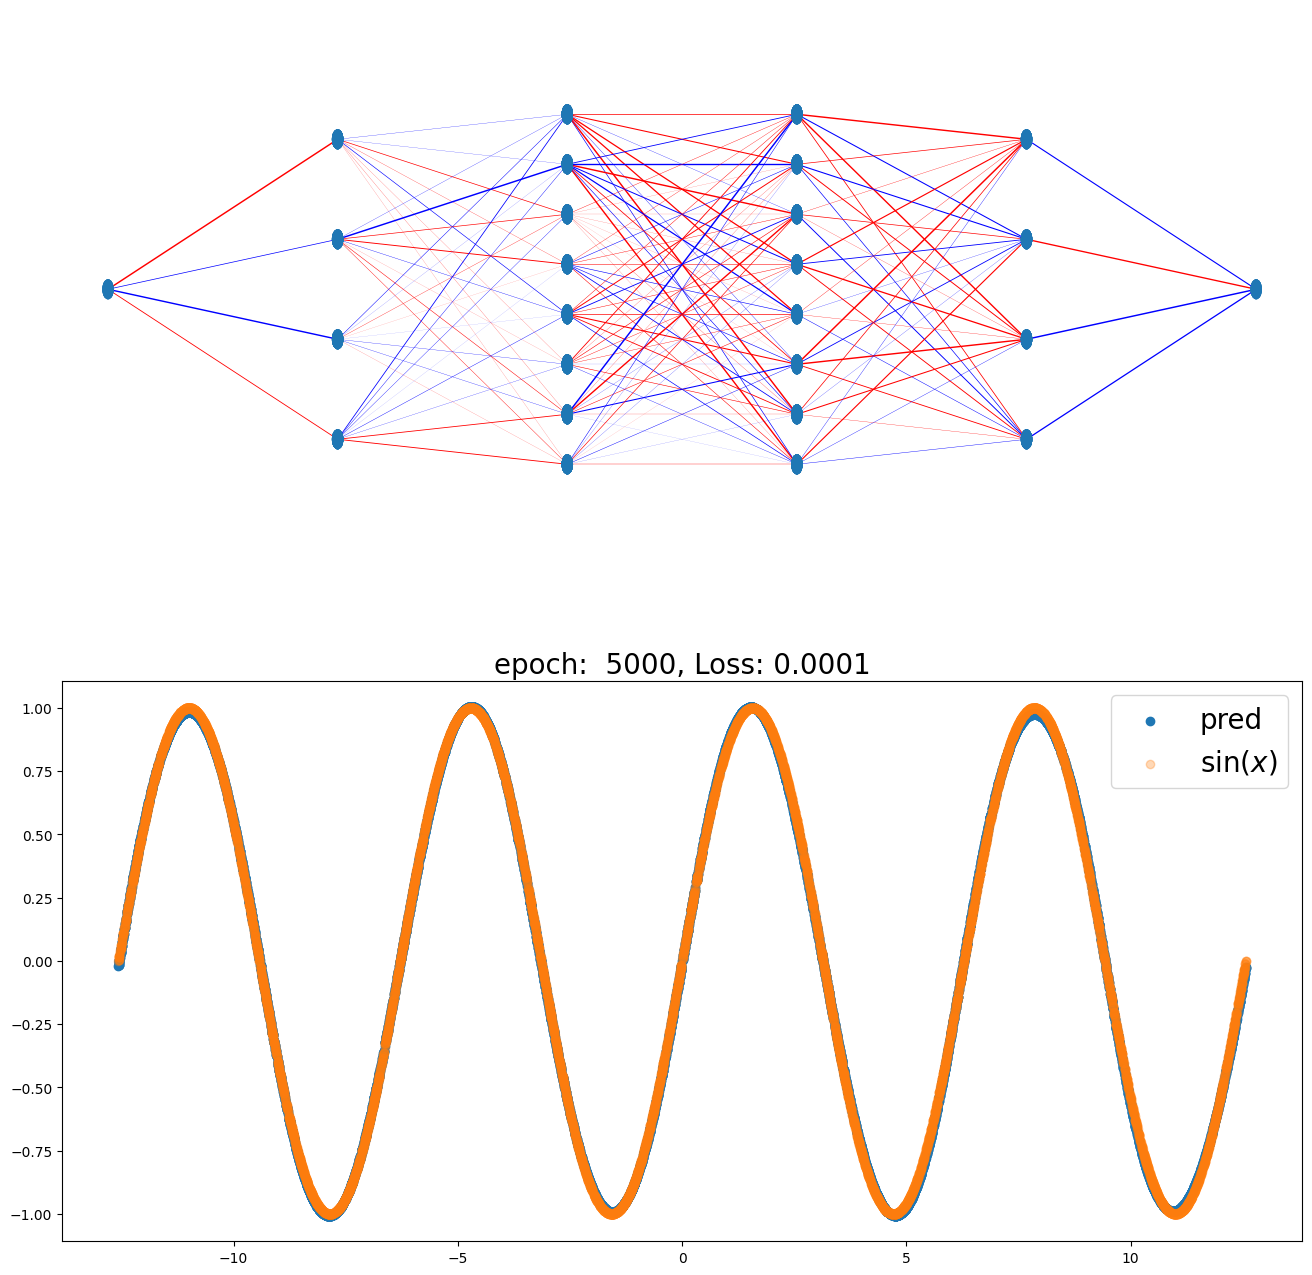

In [4]:
# sin(x)
mlp = BioBaseMLPND(shape=(1, 4, 8, 8, 4, 1), dim=1, out_ring=True).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=0.0)
epochs = 5000 + 1

sampler = torch.distributions.uniform.Uniform(-4, 4)
fig, axes = plt.subplots(2, 1, figsize=(16, 16))
for e in tqdm(range(epochs)):
    x = sampler.sample(torch.Size((10000, 1))).to(DEVICE) * torch.pi
    y = torch.sin(x)
    pred = mlp(x)
    
    optimizer.zero_grad()
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()
    if e % 50 == 0:
        axes[0].cla()
        axes[1].cla()
        
        mlp.plot(ax=axes[0], mode="h")
        
        axes[1].scatter(x.cpu().detach().numpy(), pred.cpu().detach().numpy(), label="pred")
        axes[1].scatter(x.cpu().detach().numpy(), y.cpu().detach().numpy(), label="sin($x$)", alpha=0.3)
        axes[1].set_title(f"epoch: {e:5d}, Loss: {loss.item():.4f}", fontsize=20)
        axes[1].legend(fontsize=20)
        
        p = save_path / "sin"
        p.mkdir(parents=True, exist_ok=True)
        plt.savefig(p / f"{e:05d}.png")

  0%|          | 0/5001 [00:00<?, ?it/s]

/mnt/g/ubuntu/research/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


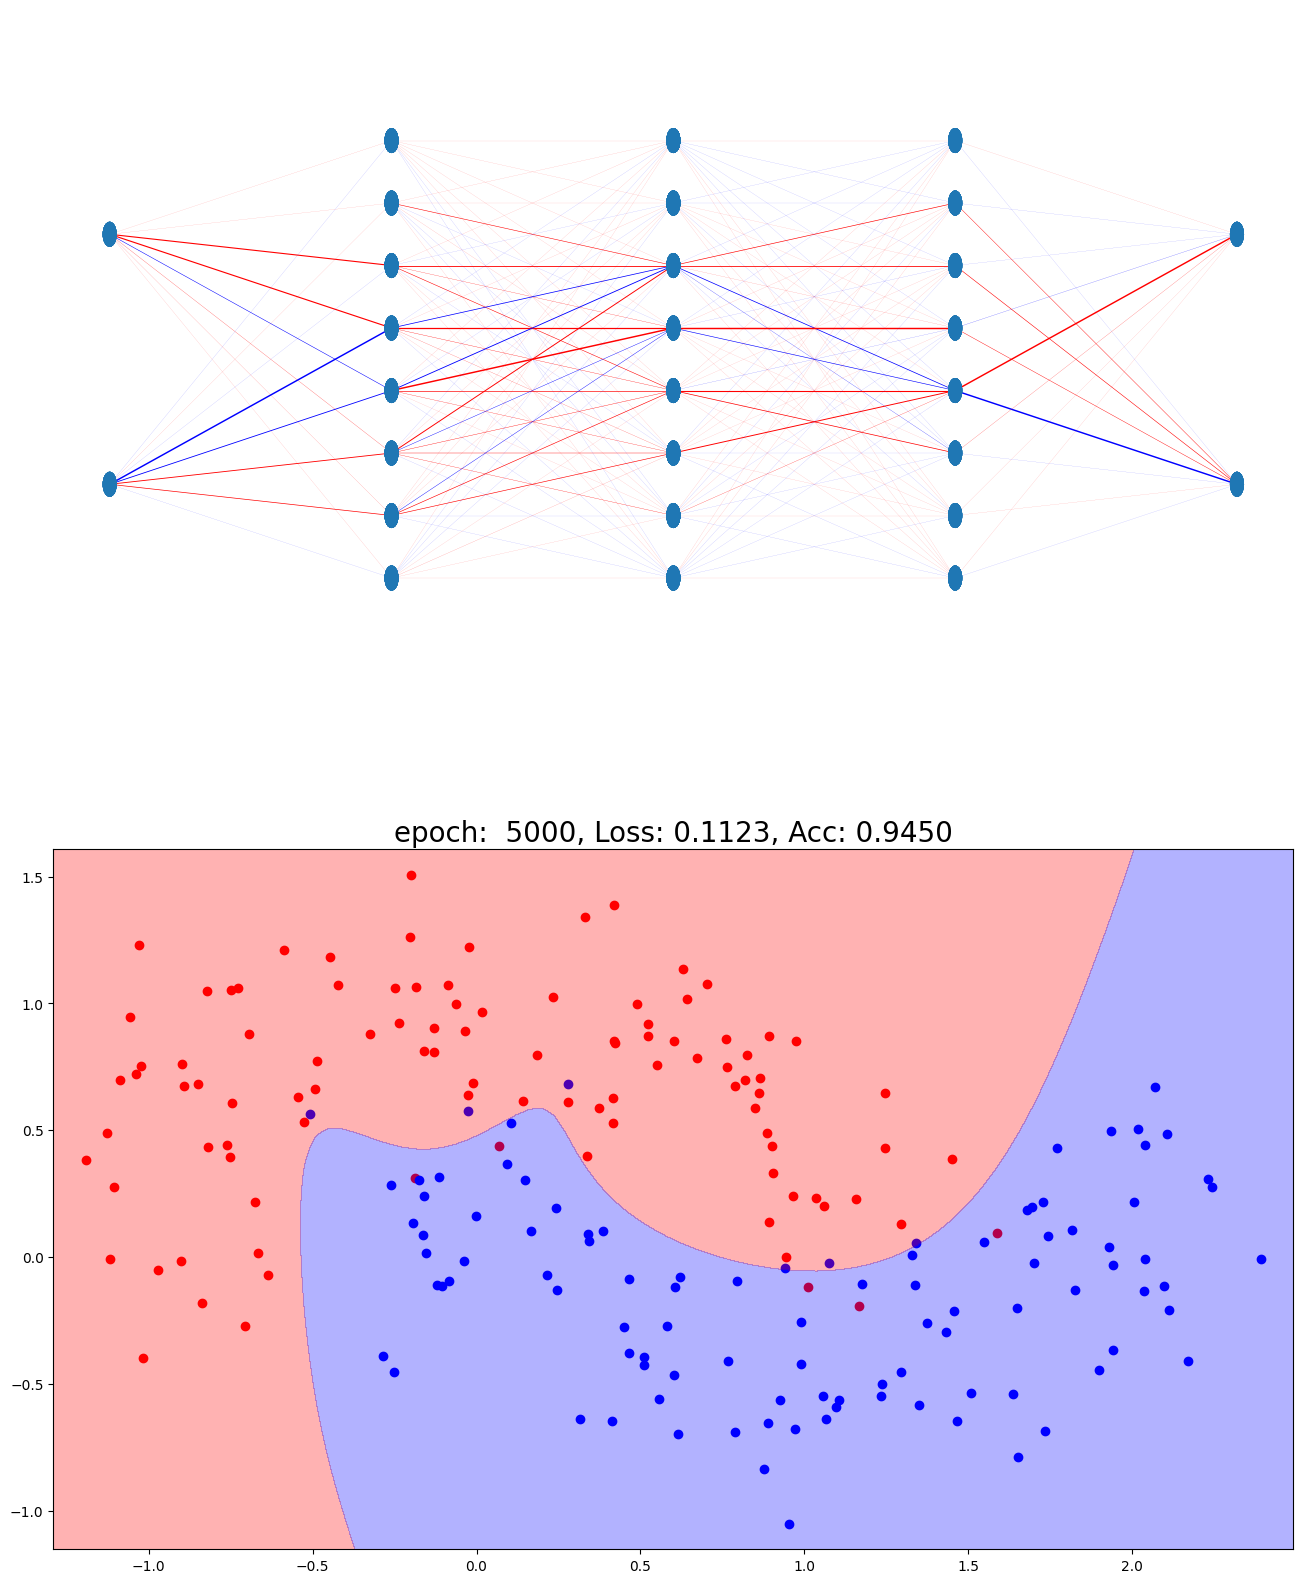

In [5]:
# two_moons
from sklearn.datasets import make_moons

n_sample = 250
noise = 0.25
train_data, train_label = make_moons(n_samples=n_sample, noise=noise)
color = ['red', 'blue']

# for i in range(n_sample):
#     plt.scatter(train_data[i, 0], train_data[i, 1],color=color[train_label[i]])
# plt.show()

train_data = torch.tensor(train_data, dtype=torch.float, requires_grad=True)
train_label = torch.tensor(train_label, dtype=torch.long)

test_data, test_label = make_moons(n_samples=n_sample // 4, noise=noise)
test_data = torch.tensor(test_data, dtype=torch.float, requires_grad=True)
test_label = torch.tensor(test_label, dtype=torch.long)

mlp = BioBaseMLPND(shape=(2, 8, 8, 8, 2), dim=1, out_ring=True)
optimizer = torch.optim.AdamW(mlp.parameters(), lr=2e-3, weight_decay=0.0)
epochs = 5000 + 1
loss_fn = nn.CrossEntropyLoss()

mlp.to(DEVICE)

fig, axes = plt.subplots(2, 1, figsize=(16, 20))
for e in tqdm(range(epochs)):
    pred_label = mlp(train_data.to(DEVICE)).cpu()
    
    optimizer.zero_grad()
    loss = loss_fn(pred_label, train_label)
    acc = torch.mean((torch.argmax(pred_label, dim=1) == train_label).float())
    
    pred_test = mlp(test_data.to(DEVICE)).cpu()
    loss_test = loss_fn(pred_test, test_label)
    acc_test = torch.mean((torch.argmax(pred_test, dim=1) == test_label).float())
    connection_cost = mlp.compute_connection_cost(weight_factor=1.0)
    total_loss = loss + connection_cost * 0.01
    
    total_loss.backward()
    optimizer.step()
    if (e + 1) % 200 == 0:
        mlp.relocate()
    
    if e % 50 == 0:
        axes[0].cla()
        axes[1].cla()
        
        mlp.plot(ax=axes[0], mode="h")
        plot_data = train_data.clone().cpu().detach().numpy()
        plot_label = train_label.clone().cpu().detach().numpy()
        for i in range(n_sample):
            axes[1].scatter(plot_data[i, 0], plot_data[i, 1], color=color[plot_label[i]])
        
        start_x = train_data[:, 0].min() - 0.1
        end_x = train_data[:, 0].max() + 0.1
        start_y = train_data[:, 1].min() - 0.1
        end_y = train_data[:, 1].max() + 0.1
        x = torch.linspace(start_x.item(), end_x.item(), 100)
        y = torch.linspace(start_y.item(), end_y.item(), 100)
        
        xx, yy = torch.meshgrid(x, y)
        inputs = torch.stack([xx.reshape(-1,), yy.reshape(-1,)]).permute(1, 0).to(DEVICE)
        pred = mlp(inputs).cpu().detach().numpy()
        pred = pred[:, 1] - pred[:, 0]
        
        axes[1].contourf(xx, yy, pred.reshape(100, 100), [-100, 0, 100], alpha=0.3, colors=color)
        axes[1].set_title(f"epoch: {e:5d}, Loss: {loss.item():.4f}, Acc: {acc.item():.4f}", fontsize=20)
        
        p = save_path / "two_moon"
        p.mkdir(parents=True, exist_ok=True)
        plt.savefig(p / f"{e:05d}.png")

In [8]:
# MNIST
import torchvision
from mpl_toolkits.mplot3d import Axes3D

save_path = Path("results") / "mnist" 
save_path.mkdir(parents=True, exist_ok=True)

train_datasets = torchvision.datasets.MNIST(
    root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_datasets = torchvision.datasets.MNIST(
    root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True
)
data_size = 60000

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=50, shuffle=True)

mlp = BioBaseMLPND(shape=(784, 64, 36, 10), dim=2, out_ring=True, device=DEVICE)
mlp.to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=0.0)
one_hots = torch.eye(10, 10).to(DEVICE)

# calculate initial accuracy
mlp.eval()
correct = 0
total = 0

def calc_acc(model, loader):
    correct = 0
    total = 0
    for data, labels in loader:
        logits = model(data.to(DEVICE))
        predicted_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(predicted_labels == labels.to(DEVICE))
        total += data.size(0)
    return correct / total

with torch.no_grad():
    print("Initial accuracy: {0:.4f}".format(calc_acc(mlp, test_loader)))

train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

best_train_loss = 1e4
best_test_loss = 1e4
best_train_acc = 0.0
best_test_acc = 0.0

epochs = 10 + 1

for e in tqdm(range(epochs)):
    mlp.train()
    lmd = 0.0025
    loss_train = torch.tensor(0.0)
    for step, (data, labels) in enumerate(train_loader):
        if step == 400:
            lmd = 0.01
        elif (step + 1) % 600 == 0:
            lmd *= 10
        if step % 300 == 0:
            fig = plt.figure(figsize=(16, 16))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(
                mlp.linear_layers[0].in_coordinates[:, 0].cpu().detach().numpy(),
                mlp.linear_layers[0].in_coordinates[:, 1].cpu().detach().numpy(),
                [0] * mlp.shape[0],
                s = 50, alpha = 0.5, c = train_datasets[46][0][0].cpu().detach().numpy()[:, ::-1].reshape(-1, )
            )
            
            for i in range(1, len(mlp.shape) - 1):
                ax.scatter(
                    mlp.linear_layers[i].in_coordinates[:, 0].cpu().detach().numpy(),
                    mlp.linear_layers[i].in_coordinates[:, 1].cpu().detach().numpy(),
                    [i] * mlp.shape[i],
                    s = 10, alpha = 0.25, c = "black",
                )
            
            ax.scatter(
                mlp.linear_layers[-1].out_coordinates[:, 0].cpu().detach().numpy(),
                mlp.linear_layers[-1].out_coordinates[:, 1].cpu().detach().numpy(),
                [len(mlp.shape) - 1] * mlp.shape[-1],
                s = 25, alpha = 0.75, c = "black",
            )
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_zlim(0, len(mlp.shape) - 0.925)

            for spine in ax.spines.values():
                spine.set_visible(False)
            plt.tight_layout()
            
            for i in range(len(mlp.shape) - 1):
                biolinear: BioBaseLinear = mlp.linear_layers[i]
                p = biolinear.linear.weight.clone().cpu()
                p = p / torch.abs(p).max()
                for j in range(p.shape[0]):
                    for k in range(p.shape[1]):
                        out_coord = biolinear.out_coordinates[j].cpu().detach().numpy()
                        in_coord = biolinear.in_coordinates[k].cpu().detach().numpy()
                        ax.plot(
                            [out_coord[0], in_coord[0]],
                            [out_coord[1], in_coord[1]],
                            [i + 1, i],
                            lw = torch.abs(p[j, k]).item() * 4 + 0.01,
                            color="blue" if p[j, k] > 0 else "red",
                            alpha = 0.5
                        )

            ring = mlp.linear_layers[-1].out_coordinates.cpu().detach().numpy()
            for i in range(ring.shape[0]):
                ax.text(
                    ring[i, 0], ring[i, 1], len(mlp.shape) - 1 + 0.05,
                    f"{mlp.out_permutation.long()[i].item()}",
                )

            ax.view_init(20, 150)
            fig.suptitle(f"epoch: {e:2d}, step; {step:5d}", fontsize=32)
            ax.axis("off")
            plt.savefig(save_path / f"epoch_{e:02d}_step_{step:05d}.png", dpi=400, bbox_inches='tight', pad_inches=0)

            plt.cla()
            plt.close()
        optimizer.zero_grad()
        pred = mlp(data.to(DEVICE))
        loss_train = loss_fn(pred, one_hots[labels]).cpu()
        connection_cost = mlp.compute_connection_cost(weight_factor=2.0, no_penalize_last=True)
        total_loss = loss_train + connection_cost * lmd
        total_loss.backward()
        optimizer.step()
    
        if step % 600 == 0:
            mlp.eval()
            with torch.no_grad():
                train_accuracies.append(calc_acc(mlp, train_loader))
                test_accuracies.append(calc_acc(mlp, test_loader))
                train_losses.append(loss_train.item())

                loss_test = torch.tensor(0.0)
                for test_data, test_labels in test_loader:
                    pred_test = mlp(test_data.to(DEVICE))
                    loss_test += loss_fn(pred_test, one_hots[test_labels]).cpu()
                
                loss_test /= len(test_loader)
                test_losses.append(loss_test.item())

                if train_accuracies[-1] > best_train_acc:
                    best_train_acc = train_accuracies[-1]
                if test_accuracies[-1] > best_test_acc:
                    best_test_acc = test_accuracies[-1]
                if train_losses[-1] < best_train_loss:
                    best_train_loss = train_losses[-1]
                if test_losses[-1] < best_test_loss:
                    best_test_loss = test_losses[-1]
            
            title = f"Epoch: {e:5d}, Step: {step:5d}, Train Loss: {loss_train.item():.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}"
            tqdm.write(title)

        if (step + 1) % 400 == 0:
            mlp.relocate()

Initial accuracy: 0.1135


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch:     0, Step:     0, Train Loss: 0.1155, Train Acc: 0.1155, Test Loss: 0.1080, Test Acc: 0.1166
Epoch:     0, Step:   600, Train Loss: 0.0187, Train Acc: 0.9203, Test Loss: 0.0198, Test Acc: 0.9212
Epoch:     1, Step:     0, Train Loss: 0.0237, Train Acc: 0.9344, Test Loss: 0.0152, Test Acc: 0.9360
Epoch:     1, Step:   600, Train Loss: 0.0115, Train Acc: 0.9459, Test Loss: 0.0128, Test Acc: 0.9457
Epoch:     2, Step:     0, Train Loss: 0.1528, Train Acc: 0.1831, Test Loss: 0.1445, Test Acc: 0.1811
Epoch:     2, Step:   600, Train Loss: 0.0117, Train Acc: 0.9512, Test Loss: 0.0119, Test Acc: 0.9493
Epoch:     3, Step:     0, Train Loss: 0.0092, Train Acc: 0.9524, Test Loss: 0.0117, Test Acc: 0.9511
Epoch:     3, Step:   600, Train Loss: 0.0078, Train Acc: 0.9623, Test Loss: 0.0095, Test Acc: 0.9599
Epoch:     4, Step:     0, Train Loss: 0.0059, Train Acc: 0.9612, Test Loss: 0.0099, Test Acc: 0.9595
Epoch:     4, Step:   600, Train Loss: 0.0044, Train Acc: 0.9675, Test Loss: 0.008

In [3]:
from PIL import Image
from pathlib import Path
name ="mnist"
files = sorted(( Path("results")  / name ).glob("*.png"))
images = list(im.resize((640, 640)) for im in map(lambda file: Image.open(file), files))
images[0].save( Path("results")  / name / f"{name}_2.gif", save_all=True, append_images=images[1:], duration=100, loop=0)